In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
rootDir_I = 'L:/DATA/Alouette_I/BATCH_I_Run2/'
resultDir_I = rootDir_I + '05_result/'
logDir_I = rootDir_I + '06_log/'

In [3]:
rootDir_II = 'L:/DATA/Alouette_I/BATCH_II_Run2/'
resultDir_II = rootDir_II + '05_result/'
logDir_II = rootDir_II + '06_log/'

In [4]:
rootDir_tot = 'L:/DATA/Alouette_I/Total/'
resultDir_tot = rootDir_tot + '05_result/'
logDir_tot = rootDir_tot + '06_log/'

In [10]:
def analyze_batch(filename, batch_name, category_type, total_df):
    df = pd.read_csv (filename)
    total = len(df)
    print (f'Number of Images Analyzed in {batch_name}: {total}')
    
    #Batch Summary
    df_filter = df.loc[df['Issue']!= 'None']
    filtered_down = len (df_filter)
    print (f' Number of Ionograms categorized correctly consistently in {batch_name}, {category_type}: {total - filtered_down}')
    
    #Success Rate:
    success_rate = (total - filtered_down)/total
    Estimation = round (success_rate * total_df)
    print (f' Estimated success rate out of {batch_name} with {total_df} ionogram: {Estimation}')

    
    print ('Element Analysis:')
    
    categorical_columns = ['year','Day_1','Day_2','Day_3','Hour_1','Hour_2','Min_1',
                       'Min_2','Sec_1','Sec_2','station_1','station_2']
    column_sums = {}
    accuracy_data = []
    confidence_level = 0.95
    z_score = 1.96 #norm.ppf(1-(1-confidence_level)/2)
    
    for column in categorical_columns:
        col_sum = df[column].sum()
        column_sums[column] = col_sum
        p = col_sum / total
        accuracy_percent = p*100
        sample_error = np.sqrt(p*(1-p)/total)*100
        confidence_interval = z_score*sample_error
        
        print(f'Number of "{column}" element categorized correctly:' , col_sum)
        print (f'Percent reading accuracy of the "{column}" element: {accuracy_percent:.2f}%')
        print (f'Sample Error for "{column}" element: {sample_error:.2f}')
        print (f'Confidence Interval for the "{column}" element: {confidence_interval:.2f}')
        
        accuracy_data.append ((column, accuracy_percent,sample_error, confidence_interval))
        
   
    #plotting
    fig = plt.figure(figsize = (10, 5))
    categories, accuracies,sample_error, confidence_interval  = zip(*accuracy_data) 
    bar = plt.bar (categories, accuracies, color = '#2C74BE', edgecolor = '#2C74BE', alpha = 0.7)
    lower_error = np.zeros_like(sample_error)
    error_bar = plt.errorbar(categories, accuracies, yerr = (lower_error, confidence_interval), 
                         linestyle = '', capsize = 10, ecolor = 'black', elinewidth = 2,
                         markeredgewidth = 2)
    plt.ylim(70, 107)

    plt.title (f"% Reading accuracy of the {category_type} metadata elements in {batch_name}", fontweight = 'bold')
    plt.xlabel(f"{category_type} metadata elements - {batch_name}", fontweight = 'bold')
    plt.ylabel(f"Reading Accuracy (%)", fontweight = 'bold')
    plt.xticks(rotation=90)
    plt.yticks (np.arange(70, 107, step = 10))
    #creating a legend
    legend_handles = [bar[0], error_bar]
    legend_labels = ['% Reading Accuracy', 'Sample Error with 95% Confidence Interval (CI)']
    plt.legend(legend_handles, legend_labels, loc = 'lower left', prop = {'weight':'bold'})

    #adding numbers on top of the error bars and bars
    for i, (bar_height, err_height, conf_interval) in enumerate (zip(accuracies, sample_error, confidence_interval)):
        plus_minus = '\u00B1' # used for +- symbol
        err_text = f'{plus_minus}{conf_interval:.2f}'
        x_pos = i
        y_pos = bar_height + err_height + conf_interval + 2
        if y_pos >100:
            y_pos = 100
        label_end = bar_height + conf_interval + 2
        plt.text(x_pos, label_end, f'{bar_height:.2f}\n{err_text}',  ha = 'center', va = 'bottom', color = 'black', fontsize = 9, weight = 'bold')
    plt.subplots_adjust(bottom = 0.25, top = 1.7, left = 0.1, right= 0.95)
    plt.show()
    return column_sums

In [36]:
def calculate_combined_accuracy(column_sums_I, column_sums_II, sample_size):
    combined_accuracy_data = []
    categorical_columns = ['year','Day_1','Day_2','Day_3','Hour_1','Hour_2','Min_1',
                       'Min_2','Sec_1','Sec_2','station_1','station_2']
    z_score = 1.96
    for column in categorical_columns:
        combined_accuracy = (column_sums_I[column] + column_sums_II[column])/ sample_size
        combined_sample_error = np.sqrt(combined_accuracy*(1-combined_accuracy)/sample_size)
        combined_confidence_interval = z_score*combined_sample_error
        combined_accuracy_data.append((column, combined_accuracy* 100, combined_sample_error* 100,  combined_confidence_interval))
    return combined_accuracy_data

In [37]:
def plot_combined_accuracy(category_type, combined_accuracy):
    fig = plt.figure(figsize = (10, 5))
    categories, accuracies,sample_error, confidence_interval  = zip(*combined_accuracy) 
    bar = plt.bar (categories, accuracies, color = '#2C74BE', edgecolor = '#2C74BE', alpha = 0.7)
    lower_error = np.zeros_like(sample_error)
    error_bar = plt.errorbar(categories, accuracies, yerr = (lower_error, confidence_interval), 
                         linestyle = '', capsize = 10, ecolor = 'black', elinewidth = 2,
                         markeredgewidth = 2)
    plt.ylim(70, 107)

    plt.title (f"% The total reading accuracy of the {category_type} metadata elements", fontweight = 'bold')
    plt.xlabel(f"{category_type} metadata elements", fontweight = 'bold')
    plt.ylabel(f"Reading Accuracy (%)", fontweight = 'bold')
    plt.xticks(rotation=90)
    plt.yticks (np.arange(70, 107, step = 10))
    #creating a legend
    legend_handles = [bar[0], error_bar]
    legend_labels = ['% Reading Accuracy', 'Sample Error with 95% Confidence Interval (CI)']
    plt.legend(legend_handles, legend_labels, loc = 'lower left', prop = {'weight':'bold'})

    #adding numbers on top of the error bars and bars
    for i, (bar_height, err_height, conf_interval) in enumerate (zip(accuracies, sample_error, confidence_interval)):
        plus_minus = '\u00B1' # used for +- symbol
        err_text = f'{plus_minus}{conf_interval:.2f}'
        x_pos = i
        y_pos = bar_height + err_height + conf_interval + 2
        if y_pos >100:
            y_pos = 100
        label_end = bar_height + conf_interval + 2
        plt.text(x_pos, label_end, f'{bar_height:.2f}\n{err_text}',  ha = 'center', va = 'bottom', color = 'black', fontsize = 9, weight = 'bold')
    plt.subplots_adjust(bottom = 0.25, top = 1.7, left = 0.1, right= 0.95)
    plt.show()
               

## Num Category

In [ ]:
#Total Number of Num Categories
df_I = pd.read_csv(resultDir_I + 'result_master.csv') #Batch I
filter_df_I = df_I[df_I['processed_image_class']=='num']
total_df_I = len(filter_df_I)
print ('Total number of NUM Ionograms in Batch I:', total_df_I)

df_II = pd.read_csv(resultDir_II + 'result_master.csv') #Batch II
filter_df_II = df_II[df_II['processed_image_class']=='num']
total_df_II = len(filter_df_II)
print ('Total number of NUM Ionograms in Batch II :', total_df_II)

Total_num = total_df_I + total_df_II #combining Batch I and Batch II num data
print ('Total number of NUM Ionograms in both batches:', Total_num)

### Batch I

In [ ]:
column_sums_I = analyze_batch ("L:/DATA/Alouette_I/BATCH_I_Run2/07_Accuracy/BatchI_QA.csv", 'Batch_I', 'NUM', total_df_I)

### Batch II

Number of Images Analyzed in Batch_2: 50
 Number of Ionograms categorized correctly consistently in Batch_2, NUM: 45
 Estimated success rate out of Batch_2 with 114045 ionogram: 102640
Element Analysis:
Number of "year" element categorized correctly: 45
Percent reading accuracy of the "year" element: 90.00%
Sample Error for "year" element: 4.24
Confidence Interval for the "year" element: 8.32
Number of "Day_1" element categorized correctly: 46
Percent reading accuracy of the "Day_1" element: 92.00%
Sample Error for "Day_1" element: 3.84
Confidence Interval for the "Day_1" element: 7.52
Number of "Day_2" element categorized correctly: 46
Percent reading accuracy of the "Day_2" element: 92.00%
Sample Error for "Day_2" element: 3.84
Confidence Interval for the "Day_2" element: 7.52
Number of "Day_3" element categorized correctly: 45
Percent reading accuracy of the "Day_3" element: 90.00%
Sample Error for "Day_3" element: 4.24
Confidence Interval for the "Day_3" element: 8.32
Number of "Ho

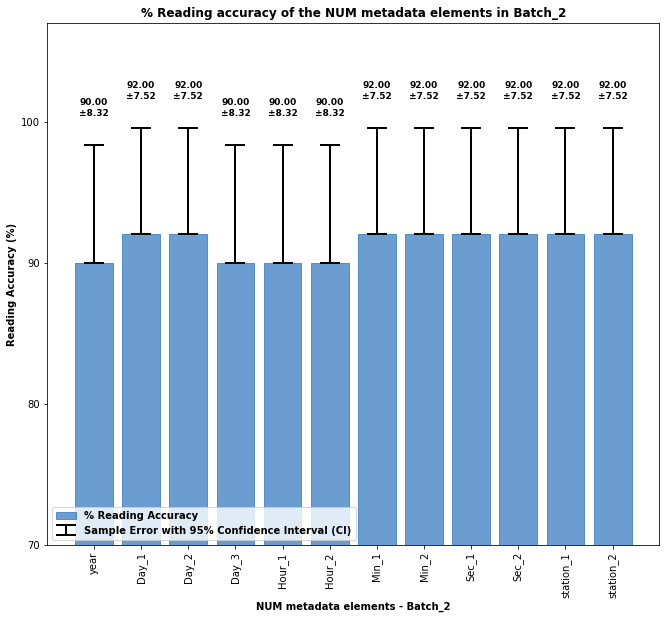

In [15]:
column_sums_II = analyze_batch ("L:/DATA/Alouette_I/BATCH_II_Run2/07_MQA/Batch2_QA_num.csv", 'Batch_2', 'NUM',total_df_II)

### Total NUM category analysis

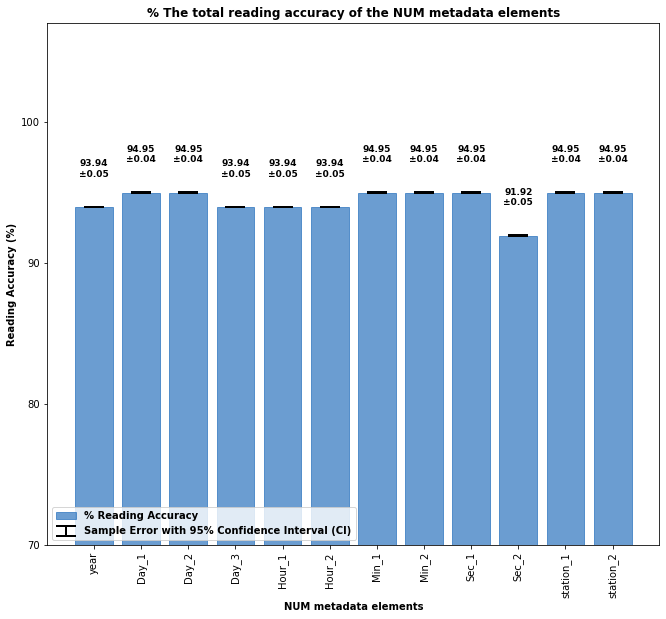

In [34]:
combined_accuracy_data = calculate_combined_accuracy(column_sums_I, column_sums_II, 99)
plot_combined_accuracy('NUM', combined_accuracy_data)

## NUM2 category

In [19]:
#Total Number of Num Categories
df_num2_1 = pd.read_csv(resultDir_I + 'result_master.csv') #Batch I
filter_df_num2_1 = df_num2_1[df_num2_1['processed_image_class']=='num2']
total_df_num2_1 = len(filter_df_num2_1)
print ('Total number of NUM2 Ionograms in Batch I:', total_df_num2_1)

df_num2_II = pd.read_csv(resultDir_II + 'result_master.csv') #Batch II
filter_df_num2_II = df_num2_II[df_num2_II['processed_image_class']=='num2']
total_df_num2_II = len(filter_df_num2_II)
print ('Total number of NUM2 Ionograms in Batch II :', total_df_num2_II)

df_num2_total = pd.read_csv(resultDir_tot + 'result_master.csv')
filter_df_total= df_num2_total[df_num2_total['processed_image_class']=='num2']
total_df_num2 = len(filter_df_total)
print('Total number of NUM2 Ionograms in both batches:', total_df_num2)

Total number of NUM2 Ionograms in Batch I: 38149
Total number of NUM2 Ionograms in Batch II : 87924
Total number of NUM2 Ionograms in both batches: 126073


### Batch I

Number of Images Analyzed in Batch_I: 30
 Number of Ionograms categorized correctly consistently in Batch_I, NUM2: 21
 Estimated success rate out of Batch_I with 38149 ionogram: 26704
Element Analysis:
Number of "year" element categorized correctly: 30
Percent reading accuracy of the "year" element: 100.00%
Sample Error for "year" element: 0.00
Confidence Interval for the "year" element: 0.00
Number of "Day_1" element categorized correctly: 30
Percent reading accuracy of the "Day_1" element: 100.00%
Sample Error for "Day_1" element: 0.00
Confidence Interval for the "Day_1" element: 0.00
Number of "Day_2" element categorized correctly: 26
Percent reading accuracy of the "Day_2" element: 86.67%
Sample Error for "Day_2" element: 6.21
Confidence Interval for the "Day_2" element: 12.16
Number of "Day_3" element categorized correctly: 25
Percent reading accuracy of the "Day_3" element: 83.33%
Sample Error for "Day_3" element: 6.80
Confidence Interval for the "Day_3" element: 13.34
Number of 

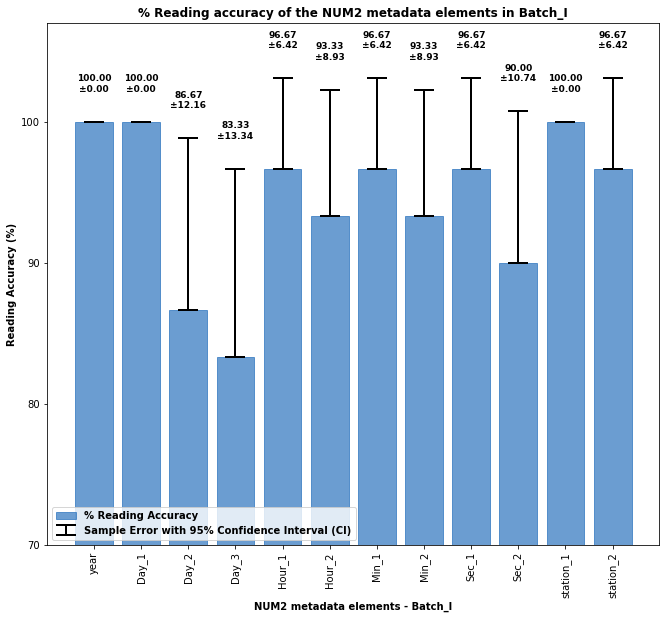

In [20]:
column_sums_num2I = analyze_batch ("L:/DATA/Alouette_I/BATCH_I_Run2/07_Accuracy/BatchI_num2_QA.csv", 'Batch_I', 'NUM2', total_df_num2_1)

###  Batch II

Number of Images Analyzed in Batch_II: 40
 Number of Ionograms categorized correctly consistently in Batch_II, NUM2: 31
 Estimated success rate out of Batch_II with 87924 ionogram: 68141
Element Analysis:
Number of "year" element categorized correctly: 33.0
Percent reading accuracy of the "year" element: 82.50%
Sample Error for "year" element: 6.01
Confidence Interval for the "year" element: 11.78
Number of "Day_1" element categorized correctly: 34.0
Percent reading accuracy of the "Day_1" element: 85.00%
Sample Error for "Day_1" element: 5.65
Confidence Interval for the "Day_1" element: 11.07
Number of "Day_2" element categorized correctly: 34.0
Percent reading accuracy of the "Day_2" element: 85.00%
Sample Error for "Day_2" element: 5.65
Confidence Interval for the "Day_2" element: 11.07
Number of "Day_3" element categorized correctly: 34.0
Percent reading accuracy of the "Day_3" element: 85.00%
Sample Error for "Day_3" element: 5.65
Confidence Interval for the "Day_3" element: 11.07

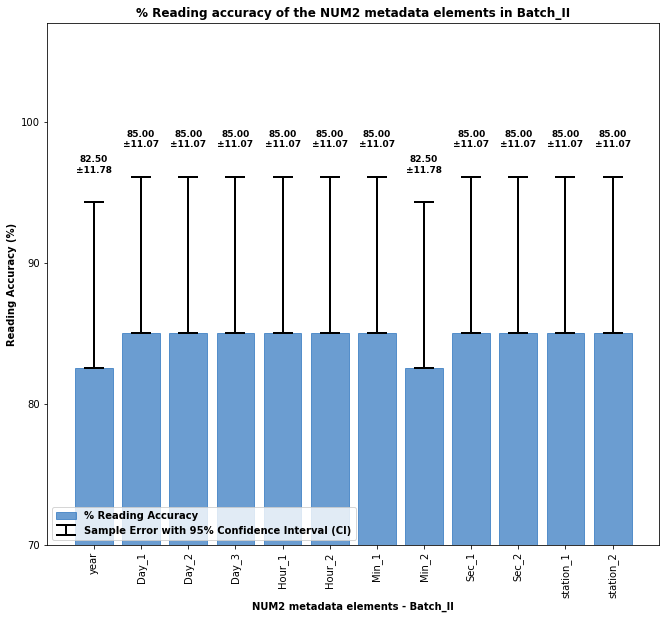

In [23]:
column_sums_num2II  = analyze_batch ("L:/DATA/Alouette_I/BATCH_II_Run2/07_MQA/Batch2_QA_num2.csv", 'Batch_II', 'NUM2', total_df_num2_II)

### Total NUM2 Category

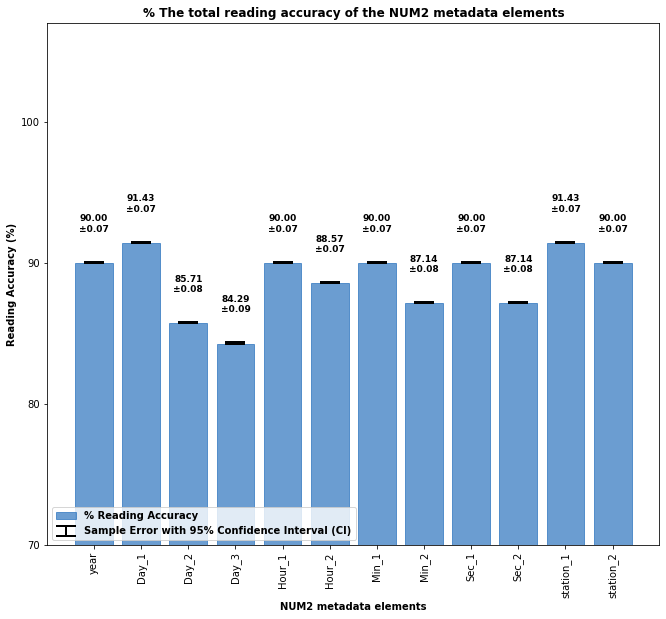

In [35]:
combined_accuracy_data = calculate_combined_accuracy(column_sums_num2I, column_sums_num2II,70)
plot_combined_accuracy('NUM2', combined_accuracy_data)

## Dot category

In [25]:
df_dot_I = pd.read_csv(resultDir_I + 'result_master.csv') #Batch I
filter_df_dot_I = df_dot_I[df_dot_I['processed_image_class']=='dot']
total_df_dot_I= len(filter_df_dot_I)
print ('Total number of dot Ionograms in BATCH I:', total_df_dot_I)

df_dot_II = pd.read_csv(resultDir_II + 'result_master.csv') #Batch II
filter_df_dot_II = df_dot_II[df_dot_II['processed_image_class']=='dot']
total_df_dot_II = len(filter_df_dot_II)
print ('Total number of dot Ionograms in BATCH II:', total_df_dot_II)

Total_dot = total_df_dot_I + total_df_dot_II  #combining Batch I and Batch II num data
print ('Total dot ionograms in Batch I and II: ', Total_dot)

Total number of dot Ionograms in BATCH I: 7784
Total number of dot Ionograms in BATCH II: 4481
Total dot ionograms in Batch I and II:  12265


Number of dot Ionograms Analyzed: 10
Number of ionograms categorized correctly: 0
Estimated Success Rate out of 7784 with consistent results: 0


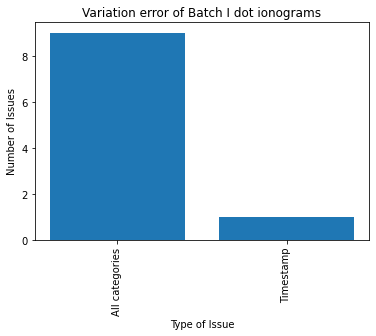

     Directory  Subdirectory       Filename
0  R014207940F           339  Image0150.png
1  R014207979F           394  Image0062.png
2  R014207929F           480  Image0242.png
3  R014207929F           476  Image0003.png
4  R014207907F           508      Image0119
6  R014207907F           512  Image0353.png
7  R014207979F           297  Image0206.png
8  R014207979F           291  Image0330.png
9  R014207940F           404  Image0224.png


In [26]:
#Batch I
df_dot_I = pd.read_csv("L:/DATA/Alouette_I/BATCH_I_Run2/07_Accuracy/BatchI_dot_QA.csv")
total_dot_I = len(df_dot_I)
print('Number of dot Ionograms Analyzed:', total_dot_I)

# filtering out correct categories
df_dot_I= df_dot_I.loc[df_dot_I['Issue'] != 'None']
filtered_down_dot_I = len(df_dot_I)
print('Number of ionograms categorized correctly:', total_dot_I - filtered_down_dot_I)

#Estimated success rate
success_rate = (total_dot_I - filtered_down_dot_I)/total_dot_I
Estimation = round(success_rate*total_df_dot_I)
print('Estimated Success Rate out of 7784 with consistent results:', Estimation)

#Plotting the variation of issues
issue_counts_dot_I = df_dot_I["Issue"].value_counts()
plt.bar(issue_counts_dot_I.index, issue_counts_dot_I.values)
plt.title ("Variation error of Batch I dot ionograms")
plt.xlabel("Type of Issue")
plt.ylabel("Number of Issues")
plt.xticks(rotation=90)
plt.show()

# Number of All categories error
df_dot_I = df_dot_I.loc[df_dot_I['Issue'] == 'All categories']
print(df_dot_I.loc[:,["Directory","Subdirectory", "Filename"]])


Number of Images Analyzed: 15
Number of Ionograms Analyzed correctly: 0
Estimated Success Rate out of 4481 with consistent results: 0.0


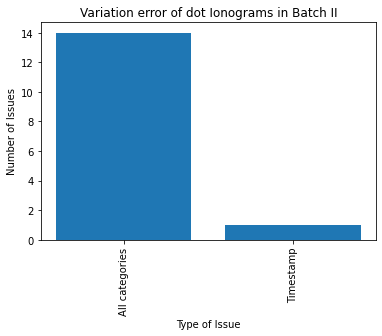

Number of NUM/NUM2 ionograms categorized as dot data by the algorithm: 14
     Directory Subdirectory filename
0   R014207961       1039-1  283.png
1   R014207961       1069-A  297.png
3   R014207944     1994-12A  131.png
4   R014207961       1076-A  288.png
5   R014207961       1039-1   19.png
6   R014207961       1069-A  263.png
7   R014207944      2042-3A  272.png
8   R014207961       1058-A  336.png
9   R014207961       1029-A  129.png
10  R014207961       1031-A  178.png
11  R014207944      2042-3A  125.png
12  R014207961       1031-A  154.png
13  R014207961       1076-A  158.png
14  R014207961       1065-A  231.png


In [27]:
#Batch II
df_dot_II = pd.read_csv("L:/DATA/Alouette_I/BATCH_II_Run2/07_MQA/Batch2_QA_dot.csv")
total_dot_II = len(df_dot_II)
print ('Number of Images Analyzed:', total_dot_II)
filtered_down_dot_II = 0 #no ionogram was analyzed correctly
print('Number of Ionograms Analyzed correctly:',filtered_down_dot_II)

#Estimated success rate
success_rate = filtered_down_dot_II/total_dot_II
Estimation = success_rate*total_df_dot_II
print('Estimated Success Rate out of 4481 with consistent results:', Estimation)

#Plotting the variation of issues
issue_counts_dot_II = df_dot_II["Issue"].value_counts()
plt.bar(issue_counts_dot_II.index, issue_counts_dot_II.values)
plt.title ("Variation error of dot Ionograms in Batch II")
plt.xlabel("Type of Issue")
plt.ylabel("Number of Issues")
plt.xticks(rotation=90)
plt.show()

# filtering out correct categories
df_dot_II = df_dot_II.loc[df_dot_II['Issue'] == 'All categories']
filtered_down_dot_II = len(df_dot_II)
print('Number of NUM/NUM2 ionograms categorized as dot data by the algorithm:', filtered_down_dot_II)
print(df_dot_II.loc[:,["Directory","Subdirectory", "filename"]])

In [28]:
#Total Dot image analysis:
Image_total_dot = total_dot_I + total_dot_II
print ('Total number of DOT Ionograms in BATCH I and II analyzed:', Image_total_dot)

Correct_total_dot = (total_dot_I - filtered_down_dot_I) + (total_dot_II - filtered_down_dot_II)
print ('Total number of Dot Ionograms in BATCH II and II analyzed correctly: ', Correct_total_dot)

#Estimated success rate
Estimation  = round(Correct_total_dot*Image_total_dot/Total_dot)
print('Estimated Success Rate of Total Dot with 12,265 ionograms:', Estimation)

#Percent certaintly
percent_tot_dot = Estimation*100/Total_dot
print('Estimated Percent certainty:' , percent_tot_dot)

Total number of DOT Ionograms in BATCH I and II analyzed: 25
Total number of Dot Ionograms in BATCH II and II analyzed correctly:  1
Estimated Success Rate of Total Dot with 12,265 ionograms: 0
Estimated Percent certainty: 0.0


## Overall summary across all categories

In [29]:
data = [
    {
        'Category': 'num',
        'Image_processed': 579054,
        'Image_manually_read': 99,
        'Estimated_correct_read': 529689,#estimation out of total num data
        '%Image_read_correctly':94,
        'p': 0,

    },
    
    {
        'Category': 'dot',
        'Image_processed':12265,
        'Image_manually_read': 25,
        'Estimated_correct_read': 0, #estimation out of total dot data
        '%Image_read_correctly':0,
    },
    {
      'Category': 'num2',
        'Image_processed':126073,
        'Image_manually_read': 70,
        'Estimated_correct_read': 105061, #estimation out of total num2 data
        '%Image_read_correctly':90 ,
    }
    
]

confidence_interval = 0.95
z_score = 1.96 #norm.ppf(1-(1-confidence_interval)/2)

for category in data: 
    image_processed = category['Image_processed']
    images_manually_read = category ['Image_manually_read']
    estimated_correct_read = category ['Estimated_correct_read']
    percent_accuracy =  category ['%Image_read_correctly']
    p = estimated_correct_read/image_processed
    sample_error = np.sqrt(p*(1-p)/image_processed)*100
    confidence_interval = z_score + sample_error
    
    category['Sample_error'] = sample_error
    category['Confidence_interval'] = confidence_interval
    
for category in data: 
    print(f"Category:{category['Category']}")
    print(f"Images Processed:{category['Image_processed']}")
    print(f"Images manually read:{category['Image_manually_read']}")
    print(f"Estimated correct reading out of total ionograms in the category:{category['Estimated_correct_read']}")
    print(f"Percent of images read correctly:{category['%Image_read_correctly']:.2f}")
    print(f"Sample Error:{category['Sample_error']:.2f}")
    print(f"Confidence Interval:{category['Confidence_interval']:.2f}\n")
    
    
    
    

Category:num
Images Processed:579054
Images manually read:99
Estimated correct reading out of total ionograms in the category:529689
Percent of images read correctly:94.00
Sample Error:0.04
Confidence Interval:2.00

Category:dot
Images Processed:12265
Images manually read:25
Estimated correct reading out of total ionograms in the category:0
Percent of images read correctly:0.00
Sample Error:0.00
Confidence Interval:1.96

Category:num2
Images Processed:126073
Images manually read:70
Estimated correct reading out of total ionograms in the category:105061
Percent of images read correctly:90.00
Sample Error:0.10
Confidence Interval:2.06

